<a href="https://colab.research.google.com/github/Manyanky/ML-MODELS/blob/master/Zindi_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Getting the necessary required headerfiles

import pandas as pd   #for our exploratory data analysis
import matplotlib.pyplot as plt  #We will need to do some plotting
import numpy as np         #Numerical calculations, linear algebra
from sklearn import metrics   #Getting the necessary evaluation matrix
# %matplotlib inline           #setting the backend of the matplotlib to the inline backend
#from matplotlib.pylablab import rcParams  #for custom styles incase of need
import seaborn as sns   #interactive plots
from datetime import datetime, timedelta,date

import plotly.offline as pyoff
import plotly.graph_objs as go

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression  #for regression
from sklearn.ensemble import RandomForestClassifier   #Random forest algorithm
from sklearn.naive_bayes import GaussianNB     #Gaussian Naive Bayes for performing online updates for the model parameters.(Normal distribution)
from sklearn.neighbors import KNeighborsClassifier  #KNN classification
from sklearn.tree import DecisionTreeClassifier  #DecisionTree
from sklearn import svm             #Support vector machine for machine learning
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.model_selection import KFold, cross_val_score  #Croos validation
from sklearn.model_selection import GridSearchCV #parameter tuning
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold      #validation

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score,average_precision_score, precision_score, confusion_matrix, classification_report



In [ ]:
#After importation of necessary modules, we are going to read data in this cell, have a look at it and performing preprocassing and cleaning if necessary

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticating and creating the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
path = 'https://drive.google.com/open?id=1gLcywbZczZX2PYvnp0b1yZ2LgRpmuOCQ'
path2 = 'https://drive.google.com/open?id=144JlB1MyZsHCDhIwGoZNo5tfqggRZI4M'
fluff, id = path.split('=')
fluff, id2 = path2.split('=')
print (id)
print (id2)

1gLcywbZczZX2PYvnp0b1yZ2LgRpmuOCQ
144JlB1MyZsHCDhIwGoZNo5tfqggRZI4M


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # we will be ignoring any kind of warnings

dataset = drive.CreateFile({'id':id}) 
dataset.GetContentFile('Train.csv')  

dataset2 = drive.CreateFile({'id':id2}) 
dataset2.GetContentFile('PID_Categories.csv')  

#Loading both test and train sets
train = pd.read_csv('Train.csv')
categories = pd.read_csv('PID_Categories.csv')
#test = pd.read_csv('test.csv')
#complete_data = [train, test]
print(train.info())
train.head()
categories.head()
#print(test.infor())
#print(complete_data.shape)
#print(complete_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66514 entries, 0 to 66513
Data columns (total 3 columns):
date    66514 non-null object
acc     66514 non-null int64
PID     66514 non-null object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB
None


,PID,Category
0,BN7D,CASHBACK
1,80G0,AIRTIME_DATA
2,WLIW,AIRTIME_DATA
3,U1DD,MOBILE_MONEY
4,T0LZ,AIRTIME_DATA


In [ ]:
#merging the train dataset and PID_Categories
train_data = pd.merge( train, categories , on = 'PID')
train_data.head()
train_data.shape

(66514, 4)

In [ ]:
#convert date field from string to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.head(10)


,date,acc,PID,Category
0,2019-12-13 11:38:33.226,256787571627,80G0,AIRTIME_DATA
1,2019-11-15 09:16:06.591,256704005298,80G0,AIRTIME_DATA
2,2019-11-19 19:51:59.545,256701950144,80G0,AIRTIME_DATA
3,2019-12-12 11:41:13.059,256702173540,80G0,AIRTIME_DATA
4,2019-12-27 18:17:24.438,256779600475,80G0,AIRTIME_DATA
5,2019-11-25 09:38:15.356,256312290313,80G0,AIRTIME_DATA
6,2019-11-12 11:05:25.387,256775875248,80G0,AIRTIME_DATA
7,2019-11-15 09:25:21.640,256702433638,80G0,AIRTIME_DATA
8,2019-11-29 19:55:36.676,256773743973,80G0,AIRTIME_DATA
9,2019-12-13 15:31:03.787,256784626274,80G0,AIRTIME_DATA


In [ ]:
#splitting the data into 2 months range to tell customer last purchase in the last two months 
data_2m = train_data[(train_data.date < date(2020,1,1)) & (train_data.date >= date(2019,11,1))].reset_index(drop=True)
data_next = train_data[(train_data.date >= date(2020,1,1)) & (train_data.date < date(2020,3,30))].reset_index(drop=True)

In [ ]:
data_user = pd.DataFrame(data_2m['acc'].unique())
data_user.columns = ['acc']

In [ ]:
#create a dataframe with acc and first purchase date in data_next
data_next_first_purchase = data_next.groupby('acc').date.min().reset_index()
data_next_first_purchase.columns = ['acc','MinPurchaseDate']
data_next_first_purchase.head()


,acc,MinPurchaseDate
0,233572490363,2020-02-04 12:31:26.365
1,256000000000,2020-01-01 20:33:05.073
2,256312226700,2020-01-30 11:25:30.513
3,256312229200,2020-01-30 11:22:15.857
4,256312290313,2020-01-07 10:14:47.990


In [ ]:
#create a dataframe with acc and last purchase date in data_2m
data_last_purchase = data_2m.groupby('acc').date.max().reset_index()
data_last_purchase.columns = ['acc','MaxPurchaseDate']

#merge the two dataframes
data_purchase_dates = pd.merge(data_last_purchase,data_next_first_purchase,on='acc',how='left')
#calculate the time difference in days:
data_purchase_dates['NextPurchaseDay'] = (data_purchase_dates['MinPurchaseDate'] - data_purchase_dates['MaxPurchaseDate']).dt.days
data_purchase_dates.head()

,acc,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,256000000000,2019-12-31 11:09:47.722,2020-01-01 20:33:05.073,1.0
1,256312290313,2019-12-20 12:07:55.368,2020-01-07 10:14:47.990,17.0
2,256393100610,2019-12-31 08:44:22.591,2020-01-01 05:39:35.528,0.0
3,256393216521,2019-12-04 08:54:35.026,2020-01-06 09:17:08.740,33.0
4,256700117509,2019-12-20 16:03:33.725,2020-02-15 12:03:10.959,56.0


In [ ]:
#merging with data_user
data_user = pd.merge(data_user, data_purchase_dates[['acc','NextPurchaseDay']],on='acc',how='left')
data_user.head()

,acc,NextPurchaseDay
0,256787571627,NaN
1,256704005298,12.0
2,256701950144,NaN
3,256702173540,NaN
4,256779600475,3.0


In [ ]:
#filling the null values with 999
data_user = data_user.fillna(999)

In [ ]:
#get max purchase date for Recency and create a dataframe
data_max_purchase = data_2m.groupby('acc').date.max().reset_index()

In [ ]:
data_max_purchase.columns = ['acc','MaxPurchaseDate']

In [ ]:
data_max_purchase['Recency'] = (data_max_purchase['MaxPurchaseDate'].max() - data_max_purchase['MaxPurchaseDate']).dt.days

In [ ]:
data_user = pd.merge(data_user, data_max_purchase[['acc','Recency']], on='acc')

In [ ]:
data_user.head()

,acc,NextPurchaseDay,Recency
0,256787571627,999.0,18
1,256704005298,12.0,10
2,256701950144,999.0,41
3,256702173540,999.0,2
4,256779600475,3.0,1


In [ ]:
data_user.Recency.describe()

count    1944.000000
mean       18.454733
std        16.349282
min         0.000000
25%         4.000000
50%        15.000000
75%        29.000000
max        60.000000
Name: Recency, dtype: float64

In [ ]:
plot_data = [
    go.Histogram(
        x=data_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

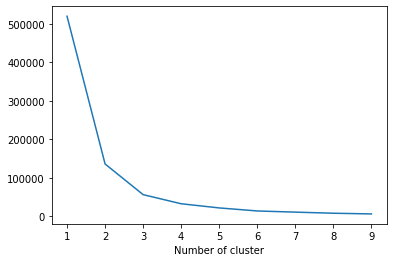

In [ ]:
sse={}
tx_recency = data_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_user[['Recency']])
data_user['RecencyCluster'] = kmeans.predict(data_user[['Recency']])

In [ ]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [ ]:
data_user = order_cluster('RecencyCluster', 'Recency',data_user,False)

In [ ]:
data_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,284.0,48.401408,5.980605,40.0,43.0,47.0,53.0,60.0
1,384.0,30.054688,4.623657,23.0,26.0,29.0,33.0,39.0
2,572.0,15.171329,4.149401,9.0,11.0,15.0,19.0,22.0
3,704.0,2.714489,2.465008,0.0,0.0,2.0,4.0,8.0


In [ ]:
#frequency
data_frequency = data_2m.groupby('acc').date.count().reset_index()

In [ ]:
data_frequency.columns = ['acc','Frequency']

In [ ]:
data_frequency.head()

,acc,Frequency
0,256000000000,202
1,256312290313,366
2,256393100610,33
3,256393216521,88
4,256700117509,3


In [ ]:
data_user = pd.merge(data_user, data_frequency, on='acc')

In [ ]:
data_user.head()

,acc,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,256787571627,999.0,18,2,2
1,256704005298,12.0,10,2,9
2,256312290313,17.0,11,2,366
3,256775875248,14.0,13,2,8
4,256702433638,12.0,10,2,15


In [ ]:
data_user.Frequency.describe()

count    1944.000000
mean       18.973765
std       101.551144
min         1.000000
25%         2.000000
50%         6.000000
75%        16.000000
max      2242.000000
Name: Frequency, dtype: float64

In [ ]:
plot_data = [
    go.Histogram(
        x=data_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

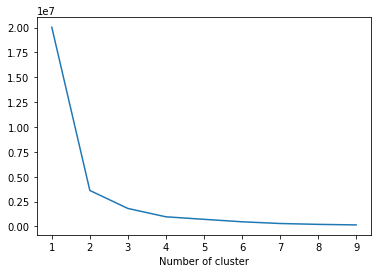

In [ ]:
sse={}
data_frequency = data_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_frequency)
    data_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_user[['Frequency']])
data_user['FrequencyCluster'] = kmeans.predict(data_user[['Frequency']])

In [ ]:
data_user.groupby('FrequencyCluster')['Frequency'].describe()



,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1915.0,10.967624,14.086648,1.0,2.0,6.0,15.0,121.0
1,4.0,1981.000000,293.032421,1658.0,1770.5,2012.0,2222.5,2242.0
2,3.0,936.666667,213.720222,711.0,837.0,963.0,1049.5,1136.0
3,22.0,234.000000,107.808472,125.0,153.5,194.0,264.0,498.0


In [ ]:
data_user = order_cluster('FrequencyCluster', 'Frequency',data_user,True)

In [ ]:
train_data.size

266056

In [ ]:
data_user.head()

,acc,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,256787571627,999.0,18,2,2,0
1,256704005298,12.0,10,2,9,0
2,256775875248,14.0,13,2,8,0
3,256702433638,12.0,10,2,15,0
4,256773743973,12.0,10,2,14,0


In [ ]:
data_user['OverallScore'] = data_user['RecencyCluster'] + data_user['FrequencyCluster']

In [ ]:
data_user.groupby('OverallScore')['Recency','Frequency'].mean()

,Recency,Frequency
OverallScore,,
0,48.401408,3.359155
1,30.055118,5.685039
2,15.251318,9.862917
3,2.839884,20.148472
4,2.777778,352.666667
5,0.000000,923.500000
6,0.000000,2038.666667


In [ ]:
data_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    284
1    381
2    569
3    687
4     18
5      2
6      3
Name: Recency, dtype: int64

In [ ]:
data_user['Segment'] = 'Low-Value'
data_user.loc[data_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
data_user.loc[data_user['OverallScore']>4,'Segment'] = 'High-Value'

In [ ]:
data_user.head()

,acc,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,Segment
0,256787571627,999.0,18,2,2,0,2,Low-Value
1,256704005298,12.0,10,2,9,0,2,Low-Value
2,256775875248,14.0,13,2,8,0,2,Low-Value
3,256702433638,12.0,10,2,15,0,2,Low-Value
4,256773743973,12.0,10,2,14,0,2,Low-Value


In [ ]:
data_2m.head()

,date,acc,PID,Category
0,2019-12-13 11:38:33.226,256787571627,80G0,AIRTIME_DATA
1,2019-11-15 09:16:06.591,256704005298,80G0,AIRTIME_DATA
2,2019-11-19 19:51:59.545,256701950144,80G0,AIRTIME_DATA
3,2019-12-12 11:41:13.059,256702173540,80G0,AIRTIME_DATA
4,2019-12-27 18:17:24.438,256779600475,80G0,AIRTIME_DATA


In [ ]:
#create a dataframe with acc, Date and PID
data_day_order =data_2m[['acc','date','PID']]

In [ ]:
#Convert Date to day
data_day_order['day'] = data_2m['date'].dt.date

In [ ]:
data_day_order = data_day_order.sort_values(['acc','date','PID'])

In [ ]:
#shifting last 3 purchase dates
data_day_order['Prevdate'] = data_day_order.groupby('acc')[['day']].shift(1)
data_day_order['T2date'] = data_day_order.groupby('acc')['day'].shift(2)
data_day_order['T3date'] = data_day_order.groupby('acc')['day'].shift(3)

In [ ]:
data_day_order.head()

,acc,date,PID,day,Prevdate,T2date,T3date
35239,256000000000,2019-11-01 09:59:02.708,3USE,2019-11-01,NaN,NaN,NaN
24991,256000000000,2019-11-01 12:32:26.062,U1DD,2019-11-01,2019-11-01,NaN,NaN
31170,256000000000,2019-11-01 13:18:33.211,Q9SJ,2019-11-01,2019-11-01,2019-11-01,NaN
29535,256000000000,2019-11-01 13:41:50.609,6Q4Z,2019-11-01,2019-11-01,2019-11-01,2019-11-01
23906,256000000000,2019-11-01 16:04:44.141,U1DD,2019-11-01,2019-11-01,2019-11-01,2019-11-01


In [ ]:
data_day_order['DayDiff'] = (data_day_order['day'] - data_day_order['Prevdate']).dt.days
data_day_order['DayDiff2'] = (data_day_order['day'] - data_day_order['T2date']).dt.days
data_day_order['DayDiff3'] = (data_day_order['day'] - data_day_order['T3date']).dt.days

In [ ]:
data_day_order.head(10)

,acc,date,PID,day,Prevdate,T2date,T3date,DayDiff,DayDiff2,DayDiff3
35239,256000000000,2019-11-01 09:59:02.708,3USE,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN
24991,256000000000,2019-11-01 12:32:26.062,U1DD,2019-11-01,2019-11-01,NaN,NaN,0.0,NaN,NaN
31170,256000000000,2019-11-01 13:18:33.211,Q9SJ,2019-11-01,2019-11-01,2019-11-01,NaN,0.0,0.0,NaN
29535,256000000000,2019-11-01 13:41:50.609,6Q4Z,2019-11-01,2019-11-01,2019-11-01,2019-11-01,0.0,0.0,0.0
23906,256000000000,2019-11-01 16:04:44.141,U1DD,2019-11-01,2019-11-01,2019-11-01,2019-11-01,0.0,0.0,0.0
25575,256000000000,2019-11-01 19:43:43.515,U1DD,2019-11-01,2019-11-01,2019-11-01,2019-11-01,0.0,0.0,0.0
25596,256000000000,2019-11-01 20:23:36.346,U1DD,2019-11-01,2019-11-01,2019-11-01,2019-11-01,0.0,0.0,0.0
22927,256000000000,2019-11-02 08:22:16.978,U1DD,2019-11-02,2019-11-01,2019-11-01,2019-11-01,1.0,1.0,1.0
21618,256000000000,2019-11-02 09:13:24.056,U1DD,2019-11-02,2019-11-02,2019-11-01,2019-11-01,0.0,1.0,1.0
24799,256000000000,2019-11-02 21:03:19.313,U1DD,2019-11-02,2019-11-02,2019-11-02,2019-11-01,0.0,0.0,1.0


In [ ]:
data_day_diff = data_day_order.groupby('acc').agg({'DayDiff': ['mean','std']}).reset_index()

In [ ]:
data_day_diff.columns = ['acc', 'DayDiffMean','DayDiffStd']

In [ ]:
data_day_diff.head()

,acc,DayDiffMean,DayDiffStd
0,256000000000,0.298507,0.529573
1,256312290313,0.134247,0.715645
2,256393100610,1.875000,5.033757
3,256393216521,0.310345,2.412710
4,256700117509,24.500000,13.435029


In [ ]:
data_day_order_last = data_day_order.drop_duplicates(subset=['acc'],keep='last')

In [ ]:
data_day_order_last.head(10)

,acc,date,PID,day,Prevdate,T2date,T3date,DayDiff,DayDiff2,DayDiff3
27460,256000000000,2019-12-31 11:09:47.722,T0LZ,2019-12-31,2019-12-31,2019-12-30,2019-12-30,0.0,1.0,1.0
533,256312290313,2019-12-20 12:07:55.368,80G0,2019-12-20,2019-12-20,2019-12-20,2019-12-20,0.0,0.0,0.0
4861,256393100610,2019-12-31 08:44:22.591,80G0,2019-12-31,2019-12-31,2019-12-31,2019-12-31,0.0,0.0,0.0
36667,256393216521,2019-12-04 08:54:35.026,93AI,2019-12-04,2019-12-04,2019-12-04,2019-12-04,0.0,0.0,0.0
12407,256700117509,2019-12-20 16:03:33.725,WLIW,2019-12-20,2019-11-16,2019-11-01,NaN,34.0,49.0,NaN
9900,256700126270,2019-12-29 05:24:12.080,WLIW,2019-12-29,2019-12-27,2019-12-27,2019-12-20,2.0,2.0,9.0
30917,256700134235,2019-12-26 17:13:09.209,P7R7,2019-12-26,2019-12-19,2019-12-18,2019-12-11,7.0,8.0,15.0
27261,256700153047,2019-12-17 14:09:41.556,T0LZ,2019-12-17,2019-12-17,2019-12-15,2019-12-15,0.0,2.0,2.0
33907,256700175005,2019-12-21 11:25:42.935,DJGS,2019-12-21,2019-12-21,2019-12-19,2019-12-19,0.0,2.0,2.0
6704,256700183880,2019-12-21 05:39:41.458,80G0,2019-12-21,2019-12-20,2019-12-20,2019-12-14,1.0,1.0,7.0


In [ ]:
data_day_order_last.head(10)

,acc,date,PID,day,Prevdate,T2date,T3date,DayDiff,DayDiff2,DayDiff3
27460,256000000000,2019-12-31 11:09:47.722,T0LZ,2019-12-31,2019-12-31,2019-12-30,2019-12-30,0.0,1.0,1.0
533,256312290313,2019-12-20 12:07:55.368,80G0,2019-12-20,2019-12-20,2019-12-20,2019-12-20,0.0,0.0,0.0
4861,256393100610,2019-12-31 08:44:22.591,80G0,2019-12-31,2019-12-31,2019-12-31,2019-12-31,0.0,0.0,0.0
36667,256393216521,2019-12-04 08:54:35.026,93AI,2019-12-04,2019-12-04,2019-12-04,2019-12-04,0.0,0.0,0.0
12407,256700117509,2019-12-20 16:03:33.725,WLIW,2019-12-20,2019-11-16,2019-11-01,NaN,34.0,49.0,NaN
9900,256700126270,2019-12-29 05:24:12.080,WLIW,2019-12-29,2019-12-27,2019-12-27,2019-12-20,2.0,2.0,9.0
30917,256700134235,2019-12-26 17:13:09.209,P7R7,2019-12-26,2019-12-19,2019-12-18,2019-12-11,7.0,8.0,15.0
27261,256700153047,2019-12-17 14:09:41.556,T0LZ,2019-12-17,2019-12-17,2019-12-15,2019-12-15,0.0,2.0,2.0
33907,256700175005,2019-12-21 11:25:42.935,DJGS,2019-12-21,2019-12-21,2019-12-19,2019-12-19,0.0,2.0,2.0
6704,256700183880,2019-12-21 05:39:41.458,80G0,2019-12-21,2019-12-20,2019-12-20,2019-12-14,1.0,1.0,7.0


In [ ]:
data_day_order_last = data_day_order_last.dropna()

In [ ]:
data_day_order_last = pd.merge(data_day_order_last, data_day_diff, on='acc')

In [ ]:
data_user = pd.merge(data_user, data_day_order_last[['acc','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='acc')

In [ ]:
data_user.head()

,acc,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,256704005298,12.0,10,2,9,0,2,Low-Value,1.0,8.0,15.0,4.500000,3.207135
1,256775875248,14.0,13,2,8,0,2,Low-Value,19.0,26.0,32.0,6.428571,5.883795
2,256702433638,12.0,10,2,15,0,2,Low-Value,1.0,1.0,7.0,3.071429,2.973325
3,256773743973,12.0,10,2,14,0,2,Low-Value,1.0,1.0,8.0,3.307692,3.146019
4,256784626274,12.0,10,2,13,0,2,Low-Value,1.0,7.0,8.0,3.583333,4.010403


In [ ]:
len(data_user)

1221

In [ ]:
#Grouping the label

In [ ]:
data_class = data_user.copy()

In [ ]:
data_class = pd.get_dummies(data_class)

In [ ]:
data_class.tail(10)

,acc,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
1211,256708395405,0.0,0,3,158,1,4,1.0,1.0,1.0,0.382166,0.711941,0,0,1
1212,256757801448,999.0,32,1,186,1,2,0.0,0.0,0.0,0.151351,0.943404,0,1,0
1213,256779227335,999.0,33,1,133,1,2,1.0,1.0,14.0,0.204545,1.189898,0,1,0
1214,256700671048,12.0,11,2,963,2,4,0.0,0.0,0.0,0.043659,1.041374,0,0,1
1215,256704708797,0.0,0,3,711,2,5,0.0,0.0,0.0,0.084507,0.429730,1,0,0
1216,256781089523,0.0,0,3,1136,2,5,0.0,0.0,0.0,0.052863,0.235381,1,0,0
1217,256701433663,0.0,0,3,2242,3,6,0.0,0.0,0.0,0.011156,0.105053,1,0,0
1218,256773668705,0.0,0,3,2216,3,6,0.0,0.0,0.0,0.027088,0.165135,1,0,0
1219,256702652564,3.0,0,3,1658,3,6,0.0,0.0,0.0,0.033193,0.182532,1,0,0
1220,256784673753,37.0,25,1,1808,3,4,0.0,0.0,0.0,0.017709,0.140071,0,0,1


In [ ]:
data_user.NextPurchaseDay.describe()

count    1221.000000
mean      291.450450
std       440.876636
min         0.000000
25%         7.000000
50%        19.000000
75%       999.000000
max       999.000000
Name: NextPurchaseDay, dtype: float64

In [ ]:
data_class['NextPurchaseDayRange'] = 2
data_class.loc[data_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
data_class.loc[data_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

In [ ]:
data_class.NextPurchaseDayRange.value_counts()/len(data_user)

2    0.511057
0    0.324324
1    0.164619
Name: NextPurchaseDayRange, dtype: float64

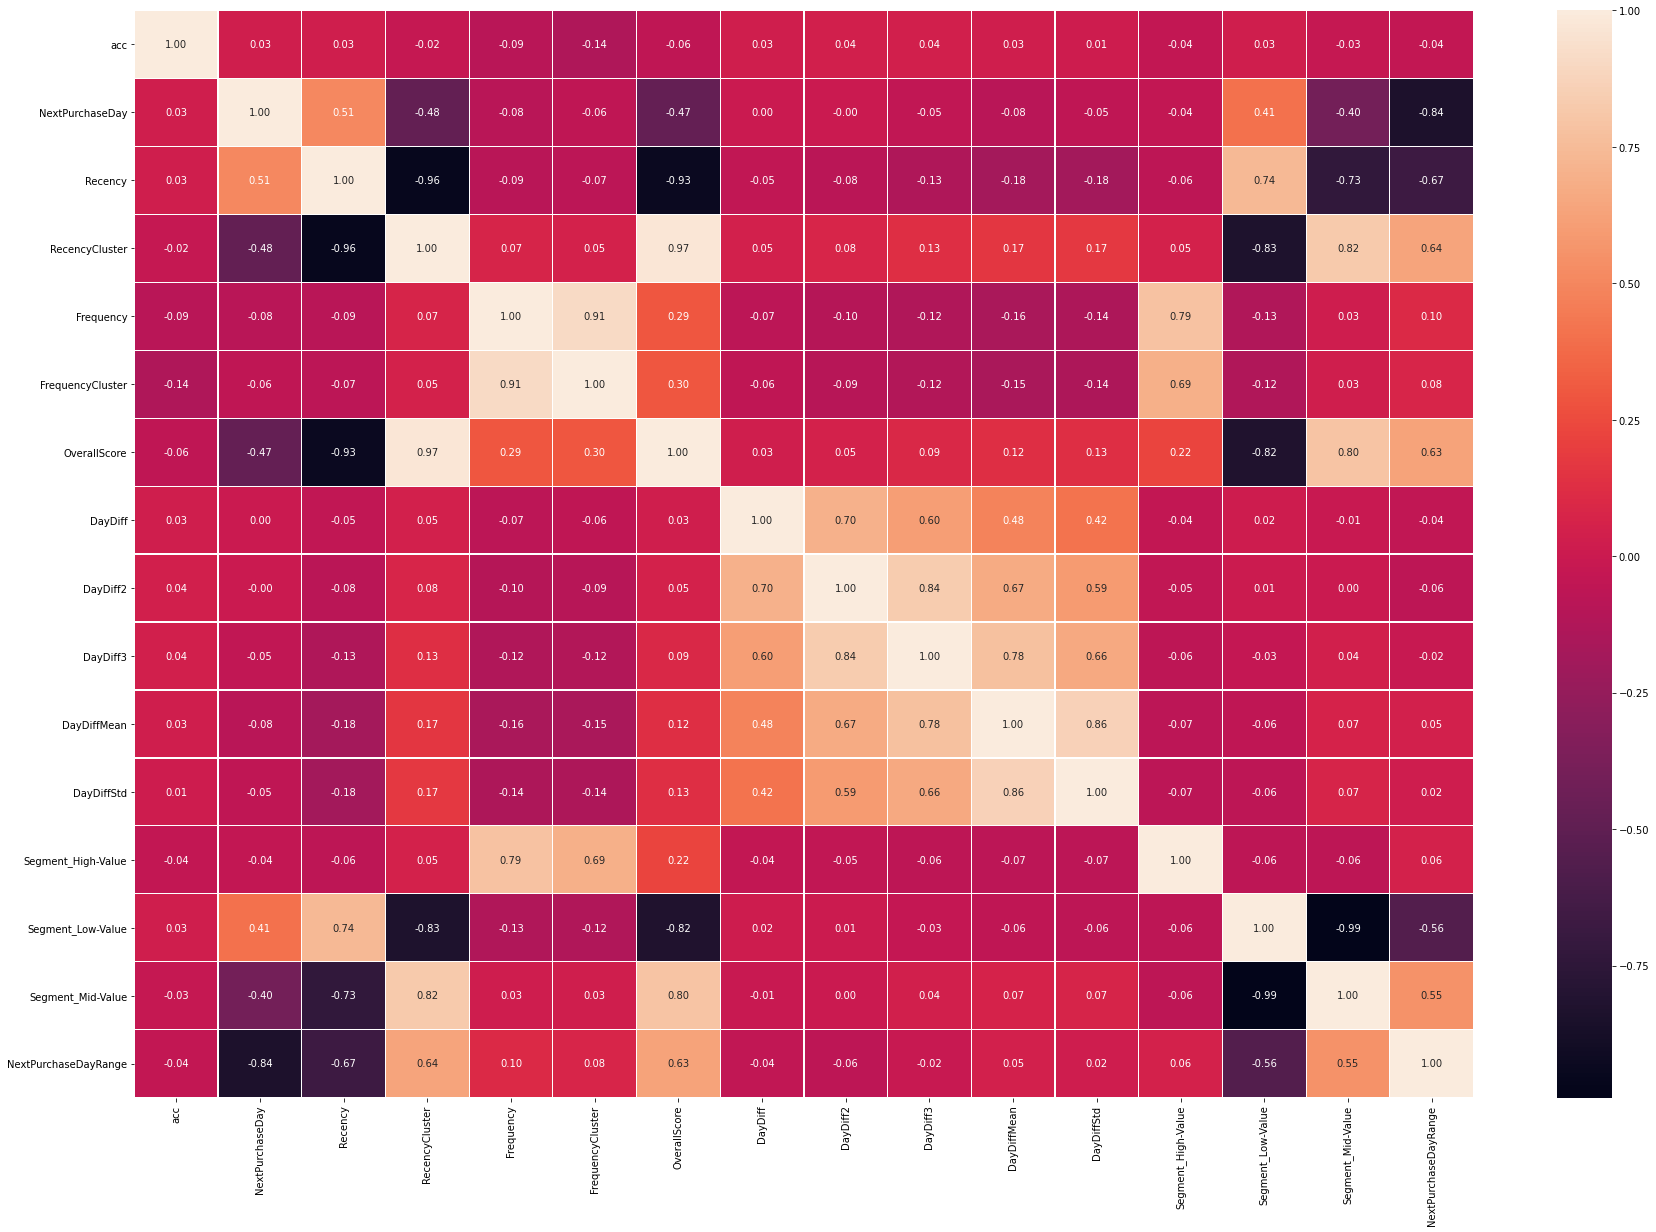

In [ ]:
corr = data_class[data_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [ ]:
data_class = data_class.drop('NextPurchaseDay',axis=1)

In [ ]:
len(data_class)

1221

In [ ]:
X, y = data_class.drop('NextPurchaseDayRange',axis=1), data_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [ ]:
data_class.size

18315

In [ ]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

In [ ]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.5102459  0.51844262]
NB [0.5102459  0.51639344]
RF [0.73770492 0.73565574]
SVC [0.5102459  0.51844262]
Dtree [0.63319672 0.63729508]
XGB [0.71516393 0.7192623 ]
KNN [0.3852459  0.38319672]


In [ ]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.85
Accuracy of XGB classifier on test set: 0.71


In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66        81
           1       0.24      0.10      0.14        42
           2       0.79      0.96      0.87       122

    accuracy                           0.71       245
   macro avg       0.56      0.57      0.55       245
weighted avg       0.65      0.71      0.67       245



In [ ]:
y_pred = xgb_model.predict(X)
y_pred.size

1221

In [ ]:
prediction = pd.DataFrame(y_pred, columns=['Prediction'])
#y_hats_df = pd.DataFrame(data = y_pred, columns = ['prediction'], index = X_test.index.copy())
#df_out = pd.merge(train, y_hats_df, how = 'left', left_index = True, right_index = True)
prediction.to_csv('submission.csv')

In [ ]:
from google.colab import files
files.download('submission.csv') 